In [1]:
#####################
###### Package ######
#####################

import pickle as pkl
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import sys

import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
# print(sys.path)
from preprocessing.preprocessing_code_190418 import preprocess, title_catcher, date_process, phone_process, time_process, title_process
from konlpy.tag import Komoran
komoran = Komoran(userdic = './data/userdict_190411.txt')

import keras
from keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, Dropout, Concatenate, Flatten, Conv1D, GlobalMaxPooling1D, TimeDistributed, SpatialDropout1D, GRU, multiply, Lambda, Reshape, MaxPooling3D, CuDNNGRU, CuDNNLSTM, Permute, RepeatVector, Multiply
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import seaborn as sn

Using TensorFlow backend.


# Data Import

In [3]:
data = pd.read_excel('./data/근로계약서v25.xlsx', sheet_name=0, header=0, skiprows=0)
data.label = [eval(item) for item in data.label.values]

In [4]:
contract_names = np.unique(data.id.values).astype(str)
data['id'] = data['id'].astype(str)
len(contract_names)

224

# Train/Valid/Test Split

In [5]:
train, test = train_test_split(contract_names, test_size = 0.2, random_state=0)
valid, test = train_test_split(test, test_size = 0.5, random_state=0)

print(len(train), len(valid), len(test))

print('Train:',train)
print('Valid:',valid)
print('Test:',test)

179 22 23
Train: ['34' '145' '197' '201' '139' '117' '189' '219' '17' '124' '110' '216'
 '23' '206' '46' '72' '5' '84' '187' '62' '53' '67' '27' '167' '41' '14'
 '123' '90' '25' '31' '61' '57' '162' '102' '20' '169' '177' '55' '181'
 '81' '52' '109' '155' '119' '87' '179' '127' '160' '112' '42' '15' '28'
 '142' '203' '21' '150' '47' '154' '220' '131' '158' '63' '147' '3' '60'
 '138' '209' '44' '11' '130' '74' '215' '218' '113' '200' '190' '99' '4'
 '94' '135' '205' '214' '51' '114' '1' '95' '96' '70' '50' '49' '86' '222'
 '24' '79' '101' '132' '182' '223' '7' '69' '85' '122' '210' '171' '191'
 '186' '224' '92' '192' '12' '120' '103' '36' '58' '66' '2' '121' '180'
 '43' '106' '133' '195' '18' '39' '134' '54' '165' '174' '129' '35' '29'
 '115' '164' '152' '32' '184' '128' '198' '33' '168' '143' '188' '148'
 '30' '178' '100' '83' '221' '176' '80' '116' '149' '217' '73' '78' '26'
 '166' '82' '211' '175' '213' '40' '194' '59' '141' '89' '71' '88' '37'
 '22' '212' '10' '104' '196' '68' '193'

In [6]:
x_all = []
y_all = []

x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []

for name in contract_names:
    temp = data[data['id']==name]
    
    temp_contract = []
    temp_answer = []
    
    for c, l in zip(temp['original_text'].values, temp['label'].values):
        temp_contract.append(c)
        temp_answer.append(l)
        
    if name in train:
        x_train.append(temp_contract)
        y_train.append(temp_answer)
    elif name in valid:
        x_valid.append(temp_contract)
        y_valid.append(temp_answer)
    elif name in test:
        x_test.append(temp_contract)
        y_test.append(temp_answer)  
        
    x_all.append(temp_contract)
    y_all.append(temp_answer)

        
print(len(x_train), len(train)) 
print(len(x_valid), len(valid)) 
print(len(x_test), len(test), end='\n\n') 
print(len(y_train), len(train))
print(len(y_valid), len(valid))
print(len(y_test), len(test))

179 179
22 22
23 23

179 179
22 22
23 23


In [7]:
np.unique(np.concatenate(data['label'].values))

array(['계약기간', '계약당사자', '계약서의명시되지않은사항', '계약서제목', '계약의분리가능성', '계약의수정.변경',
       '계약일', '계약효력발생일', '권리의무의귀속', '근로계약서교부', '근로시간', '근로형태', '근무복장',
       '근무장소', '근무평정', '근태관리', '기타', '당사자표시', '대리권행사', '목적', '보장',
       '분쟁해결및관할', '불가항력', '사고발생시책임', '상여금', '서명날인', '손해배상', '수습기간',
       '양도금지', '업무보고', '업무의내용', '역할과권리.의무', '위약금', '임금', '재해보상', '정년',
       '준거법', '준수의무', '징계', '채용결격사유', '통지의무', '퇴사절차', '퇴직금', '특약사항',
       '해지/해고', '휴일'], dtype='<U12')

In [20]:
valid_class = ['계약기간','계약당사자','계약서제목','계약의수정.변경','계약일', '근로계약서교부','근로시간','근로형태','근무장소',
             '근태관리','당사자표시','목적','분쟁해결및관할', '사고발생시책임','상여금','손해배상','수습기간','업무보고','업무의내용','역할과권리.의무','권리의무의귀속',
             '임금','준수의무','징계','퇴사절차','퇴직금','해지/해고','휴일', 'PAD']
max_row = 120

# Defined funtion

In [24]:
class_size = len(valid_class)
print(class_size)

label2num = {word: i for i, word in enumerate(valid_class)}

def labels2vecs(labels):
    output = np.zeros(class_size)
    for label in labels:
        if label in label2num.keys():
            output += np.eye(class_size)[label2num[label]]
    return output.tolist()
    
num2label = {i: word for i, word in enumerate(valid_class)}

def vecs2labels(vecs):
    output = []
    for i, vec in enumerate(vecs):
        if vec == 1:
            output.append(num2label[i])
    return output

def text_preprocess(text):
    
    text = preprocess(text)
    text = title_process(text)
    text = time_process(text)
    text = date_process(text)
    text = phone_process(text)
    text = re.sub('[^가-힣".,()~%_ ]+', '', text)
        
    return text

def y_dataset(contracts, max_row):
    labels = [[labels2vecs(line) for line in contract] for contract in contracts]
    return pad_sequences(labels, maxlen=max_row, padding='post', value=labels2vecs(['PAD']))

29


# Sentence Embedding

In [2]:
import torch
import pickle

from preprocessing.pytorch_pretrained_bert.tokenization_morp import BertTokenizer
from preprocessing.pytorch_pretrained_bert import BertModel, BertForMaskedLM

from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from eunjeon import Mecab
mecab = Mecab()

In [3]:
def do_lang(text):
    mecab_pos = mecab.pos(text)
    return_result = ''
    for i in mecab_pos:
        temp_text = i[0] + '/' + i[1] + ' '
        return_result = return_result + temp_text

    return return_result

In [4]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [5]:
def convert_examples_to_features(text_a, text_b, tokenizer, max_seq_length) :
    tokens_a = do_lang(text_a)
#     print(tokens_a)
    tokens_a = tokenizer.tokenize(tokens_a)
#     print(tokens_a)
    tokens_b = None
    if text_b :
        tokens_b = do_lang(text_b)
        tokens_b = tokenizer.tokenize(tokens_b)
        
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length-3)
    else :
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]
            
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] * len(tokens)
    
    if tokens_b:
        tokens += tokens_b + ["[SEP]"]
        segment_ids += [1] * (len(tokens_b) + 1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)
    
    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    
    return input_ids, input_mask, segment_ids

In [6]:
def sentence_embedding(input_id, segment_id):
    
    tokens_tensor = torch.tensor([input_id], dtype=torch.long, device=device)
    segment_tensor = torch.tensor([segment_id], dtype=torch.long, device=device)
    
    
    tokens_tensor = tokens_tensor.to(device)
    segment_tensor = segment_tensor.to(device)
    
    with torch.no_grad():
        encoded_layers, _, sequence_output = model(tokens_tensor, segment_tensor)
    
    sentence_embedding = encoded_layers[-1][0][0]
    
    return sentence_embedding

In [7]:
def text_to_bert(text, unit, max_seq_length):
    if len(text)==2 :
        text_a=text[0]
        text_b=text[1]
    elif len(text)==1 :
        text_a=text[0]
        text_b=False
    else :
        print('check text!')
        
    input_ids, input_mask, segment_ids = convert_examples_to_features(text_a = text_a, text_b=text_b, tokenizer=tokenizer, max_seq_length=max_seq_length)

    return sentence_embedding(input_ids, segment_ids).cpu().numpy()

In [10]:
device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained('./preprocessing/pytorch_pretrained_bert/vocab.korean_morp_mecab.list', do_lower_case=False)
model = BertModel.from_pretrained('./input','labor_bert.bin')
model.eval()
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30349, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [17]:
def sentence_embedding(input_id, segment_id):
    
    tokens_tensor = torch.tensor([input_id], dtype=torch.long, device=device)
    segment_tensor = torch.tensor([segment_id], dtype=torch.long, device=device)
    
    
    tokens_tensor = tokens_tensor.to(device)
    segment_tensor = segment_tensor.to(device)
    
    with torch.no_grad():
        encoded_layers, _, sequence_output = model(tokens_tensor, segment_tensor)
    
    sentence_embedding = encoded_layers[-1][0][0]
    
    return sentence_embedding

In [18]:
bert_train_par = [[text_to_bert(text=[text_preprocess(j)], unit='sentence', max_seq_length=120) for j in i] for i in x_train]
bert_valid_par = [[text_to_bert(text=[text_preprocess(j)], unit='sentence', max_seq_length=120) for j in i] for i in x_valid]
bert_test_par = [[text_to_bert(text=[text_preprocess(j)], unit='sentence', max_seq_length=120) for j in i] for i in x_test]

In [22]:
bert_train_par_ = pad_sequences(bert_train_par, maxlen=max_row, padding='post', dtype='float')
bert_valid_par_ = pad_sequences(bert_valid_par, maxlen=max_row, padding='post', dtype='float')
bert_test_par_ = pad_sequences(bert_test_par, maxlen=max_row, padding='post', dtype='float')

In [23]:
print('bert_train_embedding', bert_train_par_.shape)
print('bert_valid_embedding', bert_valid_par_.shape)
print('bert_test_embedding', bert_test_par_.shape)

bert_train_embedding (179, 120, 768)
bert_valid_embedding (22, 120, 768)
bert_test_embedding (23, 120, 768)


In [25]:
y_train_ = y_dataset(y_train, max_row)
y_valid_ = y_dataset(y_valid, max_row)
y_test_ = y_dataset(y_test, max_row)
y_all_ = y_dataset(y_all, max_row)

# Sentence Embedding Visualization

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/Hancom Gothic Bold.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()

In [28]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500, random_state=1104)
tsne_results = tsne.fit_transform(np.concatenate(bert_train_par))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8015 samples in 0.337s...
[t-SNE] Computed neighbors for 8015 samples in 31.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8015
[t-SNE] Computed conditional probabilities for sample 2000 / 8015
[t-SNE] Computed conditional probabilities for sample 3000 / 8015
[t-SNE] Computed conditional probabilities for sample 4000 / 8015
[t-SNE] Computed conditional probabilities for sample 5000 / 8015
[t-SNE] Computed conditional probabilities for sample 6000 / 8015
[t-SNE] Computed conditional probabilities for sample 7000 / 8015
[t-SNE] Computed conditional probabilities for sample 8000 / 8015
[t-SNE] Computed conditional probabilities for sample 8015 / 8015
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.988762
[t-SNE] KL divergence after 500 iterations: 1.059052


In [30]:
tsne_df = pd.DataFrame({'tsne_one':tsne_results[:,0], 'tsne_two':tsne_results[:,1], 'label':np.concatenate([[','.join(j) for j in i] for i in [[j if j[0] in valid_class else ['기타'] for j in i] for i in y_train]])})
tsne_df_2 = tsne_df.loc[~tsne_df['label'].str.contains(',')]

In [31]:
hue_class = ['임금','상여금','퇴직금','근태관리','계약기간','수습기간','근로형태','휴일','계약일','업무의내용', '업무보고','해지/해고','징계','준수의무','목적','근로계약서교부','사고발생시책임','권리의무의귀속','역할과권리.의무','손해배상','퇴사절차',
            '근로시간','계약당사자','근무장소','분쟁해결및관할','계약의수정.변경','계약서제목','당사자표시','기타']

In [32]:
col = ['red','red','red','red','darkgreen','darkgreen','darkgreen','purple','purple','gold','gold','coral','coral','navy','plum','khaki','darkorange','peru','maroon','orangered','black','lime','lightblue','wheat',
      'blue','maroon','grey','darksalmon','teal']

In [33]:
palette_dict = {i:j for i,j in zip(hue_class, col)}

In [35]:
palette_dict

{'임금': 'red',
 '상여금': 'red',
 '퇴직금': 'red',
 '근태관리': 'red',
 '계약기간': 'darkgreen',
 '수습기간': 'darkgreen',
 '근로형태': 'darkgreen',
 '휴일': 'purple',
 '계약일': 'purple',
 '업무의내용': 'gold',
 '업무보고': 'gold',
 '해지/해고': 'coral',
 '징계': 'coral',
 '준수의무': 'navy',
 '목적': 'plum',
 '근로계약서교부': 'khaki',
 '사고발생시책임': 'darkorange',
 '권리의무의귀속': 'peru',
 '역할과권리.의무': 'maroon',
 '손해배상': 'orangered',
 '퇴사절차': 'black',
 '근로시간': 'lime',
 '계약당사자': 'lightblue',
 '근무장소': 'wheat',
 '분쟁해결및관할': 'blue',
 '계약의수정.변경': 'maroon',
 '계약서제목': 'grey',
 '당사자표시': 'darksalmon',
 '기타': 'teal'}

<Figure size 432x288 with 0 Axes>

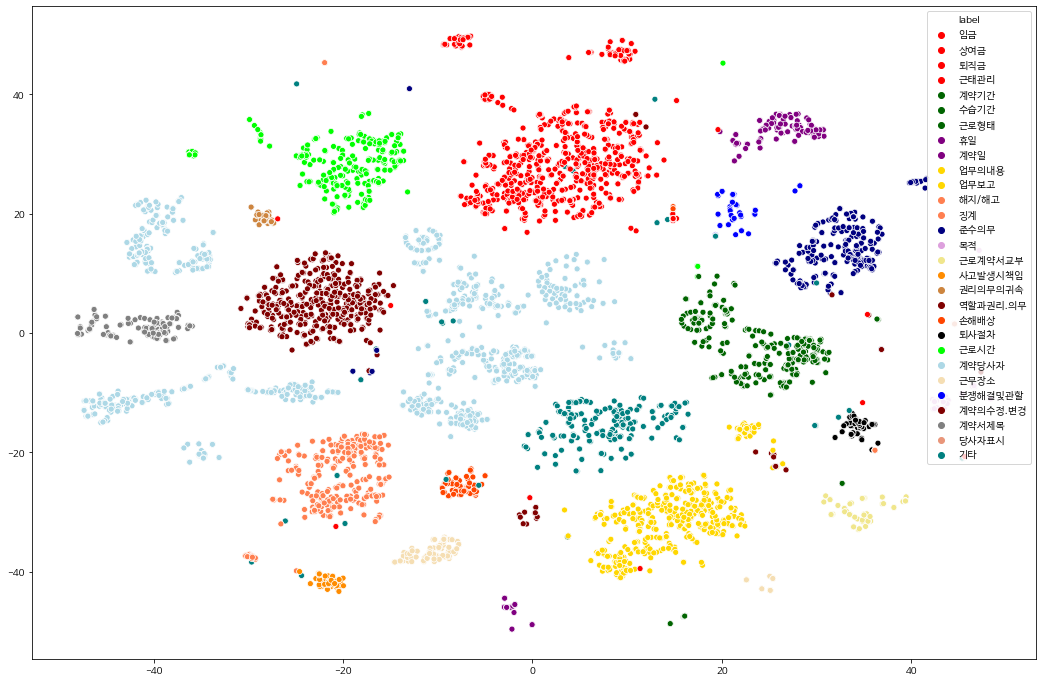

In [36]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.figure(figsize=(18,12))
plt.rc('font',family=font_name)

sns.scatterplot(x='tsne_one', y='tsne_two', hue='label',legend='full',
                hue_order=hue_class, palette=palette_dict,
                data=tsne_df_2)
fig = plt.gcf()
plt.xlabel('')
plt.ylabel('')
plt.rcParams['axes.unicode_minus'] = False
fig.savefig('./tsne_visual.png', bbox_inches = "tight", dpi=500)
# plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.)
# plt.xticks([])
# plt.yticks([])

# plt.axis('off')
plt.show()

# Model

In [19]:
# Hyper Parameter

n_words = vocab_size + 2
embed_size = 200

batch_size = 8
learning_rate = 0.0001
epochs = 500

sentence_wise_lstm_size = 100

dense_dropout = 0.5
l2_reg = regularizers.l2(0.0001)

dense_size = 128
attention_dim = 250
rnn_dim = 256

In [46]:
def paragraph_lstm():
    K.clear_session()
    np.random.seed(9311)
    
    sentence_input = Input(shape=(max_row, 768), name='sentence_input')
    lstm = Bidirectional(CuDNNLSTM(128, return_sequences=True), name='paragraph_lstm')(sentence_input)
    bn = BatchNormalization()(lstm)

    attention_layer = SeqSelfAttention(units=200, 
                                       attention_activation='sigmoid', 
                                       attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD,
                                       attention_width=60,
                                       kernel_regularizer=keras.regularizers.l2(1e-4),
                                       bias_regularizer=keras.regularizers.l1(1e-4),
                                       attention_regularizer_weight=1e-4,
                                       return_attention=True)(lstm)
#     do = Dropout(0.1)(attention_layer[0])
    bn = BatchNormalization()(attention_layer[0])
    output = Dense(class_size, activation='sigmoid')(bn)
    
    model = Model(inputs=sentence_input, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy'])
    
    attention_extractor = Model(inputs=sentence_input, outputs=attention_layer[1])
    context_extractor = Model(inputs=sentence_input, outputs=attention_layer[0])
    return model, attention_extractor, context_extractor

In [47]:
model_path = './output/wise_weight/labor_bert/{epoch:02d}-{val_loss:.4f}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_loss',
                               verbose=True,
                               save_best_only=True)

model,extractor,context = paragraph_lstm()

inputs shape (?, 120, 256)
wt shape (256, 200)
q Tensor("seq_self_attention_1/ExpandDims:0", shape=(?, 120, 1, 200), dtype=float32)
h Tensor("seq_self_attention_1/Tanh:0", shape=(?, 120, 120, 200), dtype=float32)


In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, 120, 768)          0         
_________________________________________________________________
paragraph_lstm (Bidirectiona (None, 120, 256)          919552    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 120, 256), (None, 102801    
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 256)          1024      
_________________________________________________________________
dense_1 (Dense)              (None, 120, 29)           7453      
Total params: 1,030,830
Trainable params: 1,030,318
Non-trainable params: 512
_________________________________________________________________


In [43]:
extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, 120, 768)          0         
_________________________________________________________________
paragraph_lstm (Bidirectiona (None, 120, 256)          919552    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 120, 256), (None, 102801    
Total params: 1,022,353
Trainable params: 1,022,353
Non-trainable params: 0
_________________________________________________________________


In [44]:
context.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, 120, 768)          0         
_________________________________________________________________
paragraph_lstm (Bidirectiona (None, 120, 256)          919552    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 120, 256), (None, 102801    
Total params: 1,022,353
Trainable params: 1,022,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(bert_train_par_,y_train_,
                batch_size=8,
                epochs=500,
                verbose=2,
                validation_data=[bert_valid_par_, y_valid_],
                callbacks=[checkpointer])

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(['train','valid'])
# plt.xlim(100,500)
# plt.ylim(0.001,0.1)
plt.show()

In [11]:
# model.load_weights('./output/wise_weight/.hdf5')

In [51]:
threshold = 0.5

def hst_output(output_):
    return [[vecs2labels((line_output>threshold)*1) for line_output in output] for output in output_]

def hst_model_pred(model, input_):
    out = []
    for contract in input_:
        out.extend(model.predict(np.array([contract])))
    return [[vecs2labels((line_output>threshold)*1) for line_output in output] for output in out]

def hst_model_proba(model, input_):
    out = []
    for contract in input_:
        out.extend(model.predict(np.array([contract])))
    return [[line_output[line_output>threshold] for line_output in output] for output in out]

def hst_multilabel_evaluate(class_pred, output, original_x, include_article = False):
    accuracy = []
    for i, contract in enumerate(original_x):
        contract_class_pred = class_pred[i]
        contract_output = output[i]
        for j, line in enumerate(contract):
            if include_article:
                o = contract_output[j]
                p = contract_class_pred[j]

                ans = set(o)
                pred = set(p)
                if (pred <= ans and len(pred)>0) or (len(pred)==0 and len(ans)==0):
                    score = 1
                else:
                    score = 0
                accuracy.append(score)

            else:
                if title_catcher(preprocess(line))==False:
                    o = contract_output[j]
                    p = contract_class_pred[j]

                    ans = set(o)
                    pred = set(p)
                    if (pred <= ans and len(pred)>0) or (len(pred)==0 and len(ans)==0):
                        score = 1
                    else:
                        score = 0
                    accuracy.append(score)
    return np.mean(accuracy)

# metrics test

In [52]:
train_output = hst_output(y_train_)
train_pred = hst_model_pred(model, bert_train_par_)
print('Train:', hst_multilabel_evaluate(train_pred, train_output, x_train))

valid_output = hst_output(y_valid_)
valid_pred = hst_model_pred(model, bert_valid_par_)
print('Valid:', hst_multilabel_evaluate(valid_pred, valid_output, x_valid))

test_output = hst_output(y_test_)
test_pred = hst_model_pred(model, bert_test_par_)
print('Test:', hst_multilabel_evaluate(test_pred, test_output, x_test))

Train: 0.9976620947630923
Valid: 0.8714859437751004
Test: 0.8502994011976048


In [55]:
threshold = 0.5

output_ = hst_output(y_test_)
pred_ = hst_model_pred(model, bert_test_par_)
proba_ = hst_model_proba(model, bert_test_par_)
print(len(output_), len(pred_), len(proba_))

result = pd.DataFrame()
text = []
after = []
pred = []
real = []
contract_id = []
title = []
split = []
scores = []
idx = -1
for i, contract_real in enumerate(x_test):
    contract_pred = pred_[i]
    contract_proba = proba_[i]
    contract_output = output_[i]
    for j, line_r in enumerate(contract_real):
        idx += 1
        c = contract_pred[j]
        p = contract_proba[j]
        o = contract_output[j]
        
#         c = software_postprocess(line_r, c)
#         print(c, o)
        if (set(c) <= set(o) and len(set(c))>0) or (len(set(c))==0 and len(set(o))==0):
            score = 1
        else:
            score = 0

        text.append(line_r)
        after.append(text_preprocess(line_r))
        pred.append(str(c))
        real.append(str(o))
        contract_id.append(data.id.values[idx])
        title.append(title_catcher(preprocess(line_r)))
        scores.append(score)

        if data.id.values[idx] in train:
            split.append('train')
        elif data.id.values[idx] in valid:
            split.append('valid')
        else:
            split.append('test')
                   
result = pd.DataFrame({'text': text, 'pred': pred, 'real': real, 'score': scores})
print(len(text),
len(pred),
len(real),
len(contract_id),
len(title),
len(split),
len(scores))

23 23 23
1006 1006 1006 1006 1006 1006 1006


In [56]:
result.to_excel('./output/근로계약서_분류결과.xlsx', index=False)